In [1]:
from lsst.daf.butler import Butler
import numpy as np

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

%config InlineBackend.print_figure_kwargs={'facecolor':"w"}

In [3]:
REPO="/project/hsc/gen3repo/rc2w06_ssw06"
collection="u/kannawad/gaap1"

In [4]:
butler = Butler(REPO, run=collection)

In [5]:
dataId = {'tract': 9615, 'patch':23, 'band':'i'}

In [6]:
meas = butler.get("deepCoadd_meas", **dataId)

In [24]:
deepCoadd = butler.get("deepCoadd_calexp", **dataId)
photoCalib = deepCoadd.getPhotoCalib()

In [10]:
np.isnan(meas['ext_gaap_GaapFlux_1_15x_4_0_instFlux']).sum()

269

In [11]:
psfStars = meas['calib_psf_used']

<ipython-input-14-f11b83b57158>:3: RuntimeWarning: invalid value encountered in log10
  logFluxRatio = -2.5*np.log10(fluxRatio)


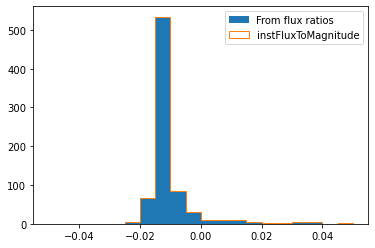

In [14]:
bins = np.linspace(-0.05, 0.05, 21)
fluxRatio = meas['ext_gaap_GaapFlux_1_15x_4_0_instFlux']/meas['ext_gaap_GaapFlux_1_15x_5_0_instFlux']
logFluxRatio = -2.5*np.log10(fluxRatio)
magDiff = photoCalib.instFluxToMagnitude(meas, 'ext_gaap_GaapFlux_1_15x_4_0')[:,0]-photoCalib.instFluxToMagnitude(meas, 'ext_gaap_GaapFlux_1_15x_5_0')[:,0]
plt.hist(logFluxRatio[psfStars], bins=bins, histtype='stepfilled',label='From flux ratios')
plt.hist(magDiff[psfStars], bins=bins, histtype='step', label='instFluxToMagnitude')
plt.legend()

In [15]:
import lsst.meas.base
import lsst.pex.config
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap
from lsst.pipe.tasks.multiBand import MeasureMergedCoaddSourcesTask as measureCoaddSources

In [16]:
from lsst.ip.diffim import modelPsfMatch

In [17]:
modelPsfMatch

<module 'lsst.ip.diffim.modelPsfMatch' from '/home/kannawad/repo/ip_diffim/python/lsst/ip/diffim/modelPsfMatch.py'>

In [18]:
from IPython.core.debugger import set_trace

In [19]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detectConfig = lsst.meas.algorithms.SourceDetectionConfig()
detectConfig.returnOriginalFootprints = False
detectConfig.thresholdValue = 10
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

In [20]:
measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)

In [23]:
exposure = lsst.afw.image.ExposureF("/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2020_26_GAAP/deepCoadd/HSC-I/9813/8,7.fits") 
table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog)

In [10]:
catalog.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['Flag'](name="deblend_deblendedAsPsf", doc="Deblender thought this source looked like a PSF"), Key['Flag'](offset=40, bit=0)),
    (Field['D'](name="deblend_psfCenter_x", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['D'](name="deblend_psfCenter_y", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=56, nElements=1)),
    (Field['D'](name="deblend_psf_instFlux", doc="If deblended-as-psf

In [25]:
measureTask.run(meas, deepCoadd)

AssertionError: 

In [6]:
catalog['ext_gaap_GaapFlux_1_15x_4_0_instFlux']

array([nan, nan, nan, ..., nan, nan, nan])

In [26]:
gaapConfig = lsst.meas.extensions.gaap.GaapFluxConfig()
gaapPlugin = lsst.meas.extensions.gaap.GaapFluxPlugin(gaapConfig, 'ext_testGaap_GaapFlux', schema, None)

In [36]:
recordId = 0
record = meas[recordId]
center = lsst.geom.Point2D(record['base_SdssShape_x'], record['base_SdssShape_y'])

In [37]:
gaapPlugin._generic.measure(record, deepCoadd, center)

KeyError: "Field with name 'ext_testGaap_GaapFlux_1_15x_4_0_instFlux' not found"

In [35]:
meas['ext_gaap_GaapFlux_1_15x_5_0_instFlux']

array([ 2.39540618,         nan,         nan, ...,  0.22339749,
       -0.09745065,  1.01069646])